# Image Classification with AlexNet

## CIFAR-10 image dataset

In [1]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

print('Training:   ', X_train.shape)
print('Validation: ', X_valid.shape)
print('Testing:    ', X_test.shape)

Training:    (45000, 32, 32, 3)
Validation:  (5000, 32, 32, 3)
Testing:     (10000, 32, 32, 3)


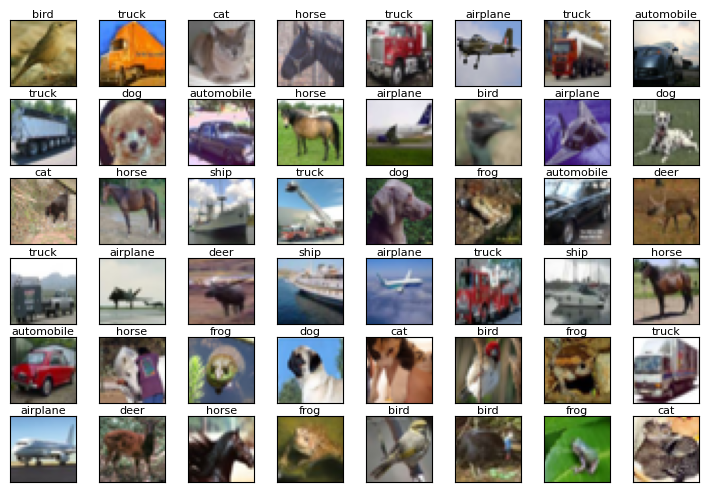

In [2]:
import matplotlib.pyplot as plt

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print the first 48 images of the training set
plt.figure(figsize=(9,6))
for i in range(48):
    image = X_train[i]
    label = class_names[y_train[i][0]]

    # Each image is a subplot at index i+1
    plt.subplot(6, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image)
    plt.title(label, fontsize=8, pad=0)

plt.show()

## Data normalization

Each feature is normalized so that different scales within the data become comparable.

In [3]:
import numpy as np
#from cv2 import resize

# resize as needed
#X_train = np.array([resize(x, (128, 128)) for x in X_train])
#X_valid = np.array([resize(x, (71, 71)) for x in X_valid])
#X_test = np.array([resize(x, (71, 71)) for x in X_test])

# Convert pixel values to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Normalize the data
mean = np.mean(X_train)
std  = np.std(X_train) + 1e-7 # (small value avoids division by zero)
X_train = (X_train - mean) / std
X_test  = (X_test - mean) / std
X_valid = (X_valid - mean) / std

## Label encoding

Each class is encoded into a one-hot vector. This encoding is suitable because there are not that many classes.

In [4]:
from keras.utils import to_categorical

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

## Data augmentation

The dataset will be expanded each training epoch with different versions of the images: rotated, translated, flipped, zoomed, and sheared, for example. This ways the model's ability to generalize is improved.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation pipeline
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, Resizing, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Model
#from keras.utils import plot_model

# Create the base model from the pre-trained model VGG16
base_model = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=y_train.shape[1])

base_model.summary()

#plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

2025-03-07 11:57:04.445776: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-07 11:57:04.445795: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-07 11:57:04.445798: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1741370224.445809 1777086 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1741370224.445824 1777086 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_layer
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [8]:
#for layer in base_model.layers[:11]:
#    layer.trainable = False

base_model.trainable = False

In [9]:
model = Sequential()

model.add(Input(shape=X_train.shape[1:]))
model.add(Resizing(224, 224))
model.add(base_model)

# option1
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation=('softmax')))

# option2
#model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.5))
#model.add(Dense(10, activation=('softmax')))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,565,386 (105.15 MB)

 Trainable params: 12,850,698 (49.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, CSVLogger, ModelCheckpoint

# Set the batch size for the training
batch_size = 64

# Set the maximum number of epochs for the training
epochs = 300

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 40 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Log epoch metrics
csv_logger = CSVLogger('vgg16_pretrained_opt1.training.log')

model_checkpoint = ModelCheckpoint(
    filepath='vgg16_pretrained_opt1.checkpoint.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=data_generator.flow(X_valid, y_valid, batch_size=batch_size),
          callbacks=[reduce_lr, early_stopping, csv_logger, model_checkpoint], 
          verbose=2)

Epoch 1/300


/Users/enrique/venv-metal/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-03-07 11:57:05.030584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


704/704 - 827s - 1s/step - accuracy: 0.3833 - loss: 6.7191 - val_accuracy: 0.6912 - val_loss: 1.5041 - learning_rate: 5.0000e-04
Epoch 2/300
704/704 - 1032s - 1s/step - accuracy: 0.5576 - loss: 2.9780 - val_accuracy: 0.7034 - val_loss: 1.1653 - learning_rate: 5.0000e-04
Epoch 3/300
704/704 - 1105s - 2s/step - accuracy: 0.5997 - loss: 1.8103 - val_accuracy: 0.7112 - val_loss: 0.9008 - learning_rate: 5.0000e-04
Epoch 4/300
704/704 - 1065s - 2s/step - accuracy: 0.6317 - loss: 1.2907 - val_accuracy: 0.7264 - val_loss: 0.8171 - learning_rate: 5.0000e-04
Epoch 5/300
704/704 - 1029s - 1s/step - accuracy: 0.6462 - loss: 1.1312 - val_accuracy: 0.7426 - val_loss: 0.7683 - learning_rate: 5.0000e-04
Epoch 6/300
704/704 - 907s - 1s/step - accuracy: 0.6603 - loss: 1.0531 - val_accuracy: 0.7322 - val_loss: 0.7708 - learning_rate: 5.0000e-04
Epoch 7/300
704/704 - 881s - 1s/step - accuracy: 0.6625 - loss: 1.0231 - val_accuracy: 0.7104 - val_loss: 0.8576 - learning_rate: 5.0000e-04
Epoch 8/300
704/704 -

KeyboardInterrupt: 